This notebook, by [felipe.alonso@urjc.es](mailto:felipe.alonso@urjc.es)

In this notebook we will analyze and compare different non-parametric methods over the `pima_indian_diabetes` dataset. Specifically, we will learn:

- How to train $K-$NN, DTs, Random Forest, Gradient Boosting and MLP algorithms.
- How to set their hyperparameters (model selection)
- How to evaluate and compare their performance (model evaluation)


In [86]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# 0. Load the data 

In [87]:
path = './data/'
filename = 'pima_indian_diabetes.csv'
df = pd.read_csv(path + filename)

# take a look to the data
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


# 1. Model Selection and evaluation on $K-$NN

We will focus first on the **classification task**, using `Outcome` as target

First, we split our data, but we do it wisely in order build a test set as similar as the train set. Since our target variables is *imbalaced* we might want to activate the `stratify` option.

Take a look to the function documentation: [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split)

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Outcome'], axis=1), df['Outcome'], 
    test_size=0.25,
    #if small samples reduce the test sample so the train is bigger. 
    random_state=42, #replicate the split, to have a homogenious split. 
    stratify=df['Outcome']
     
)

print('- Train size:', X_train.shape)
print('- Test size:', X_test.shape)

print('\n- Train target distribution: ', y_train.value_counts().values/len(y_train))
print('- Test target distribution:  ',y_test.value_counts().values/len(y_test))

- Train size: (576, 8)
- Test size: (192, 8)

- Train target distribution:  [0.65104167 0.34895833]
- Test target distribution:   [0.65104167 0.34895833]


<div class = "alert alert-success">
Run the above cell several times, does the target variable distribution change?
</div>

### Standarize/normalize variables

$K-$NN and MLP require the input data to be standarized

In [89]:
#normalize the data because this models need the data to be normalized
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm  = scaler.transform(X_test)

## 1.1 Let's set a baseline

Before running our algorithms it is always a good practice to build a baseline model, so you we have a reference of what the results should be.

- In `src.utils` you have implemented some functions to help us calculating and representing different classification metrics. 

- The `analyze_train_test_performance` function provides a comparative summary between training and test metrics.

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	79.51	73.44
SEN:	60.20	52.24
ESP:	89.87	84.80
PPV:	76.10	64.81
F1:	67.22	57.85


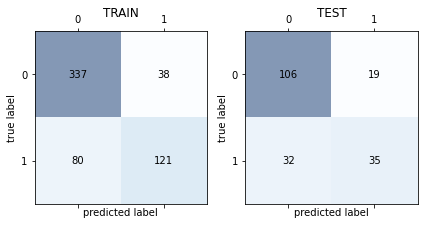

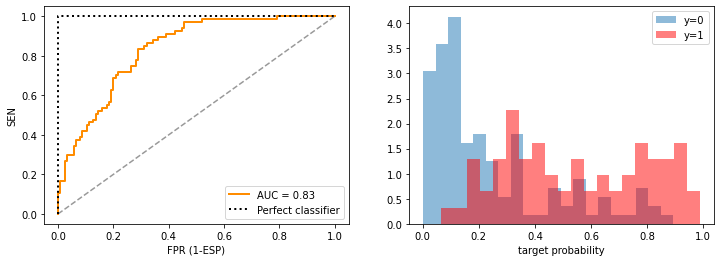

In [90]:
from sklearn.linear_model import LogisticRegression
from src.utils import analyze_train_test_performance  

# Logistic regression
lr_model = LogisticRegression().fit(X_train_norm,y_train)

# This a custom function, take a look in src.utils
analyze_train_test_performance(lr_model,X_train_norm,X_test_norm,y_train,y_test)
#difference between train and test not big enough to consider overfit.
#

The lower your target probability the more probable it is to be a 0, if your target prob is bigger then it is a 1. 

<div class = "alert alert-success">
Does this model overfit? Justify your answer
</div>

## 1.2 Model selection: *GridSearch* 

We are going to sweep different values of the parameters of each algorithm, to determine its optimal value. In this sweep, we will use a cross-validation strategy, but never the test set!

To do so, we will be using the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) function.

In [91]:
from sklearn.model_selection import GridSearchCV

# These are customized functions: should be in utils.py
def hyper_parameters_search(clf, X, y, param_grid, scorer = 'f1', cv=3):
#cross validations depends on the data amount you have. 
    
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = scorer, cv = cv)
    grid.fit(X, y)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))
    
    return grid

def plot_cv_scoring(grid, hyper_parameter, scorer = 'f1', plot_errors = False, log=False):
    
    scores = np.array(grid.cv_results_['mean_test_score'])
    std_scores = grid.cv_results_['std_test_score']
        
    params = grid.param_grid[hyper_parameter]
    
    if log:
        params = np.log10(params)
    
    if plot_errors:
        plt.errorbar(params,scores,yerr=std_scores, fmt='o-',ecolor='g')
    else:
        plt.plot(params,scores, 'o-')
    plt.xlabel(hyper_parameter,fontsize=14)
    plt.ylabel(scorer)
    plt.show()

#### Train an algorithm using `GridSearchCV`

We need to define:

- `scoring`: strategy to evaluate the performance of the cross-validated model on the validation sets. [Metrics in sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)

<div class = "alert alert-success">
Take a look to the different metrics in sklearn
</div>

- `param_grid`: dictionary with parameters names (`str`) as keys and lists of parameter settings to try as value. Example:

```python
param_grid = {'n_neighbors': range(1,25)}
```




### $K-$NN

best mean cross-validation score: 0.762
best parameters: {'n_neighbors': 21}


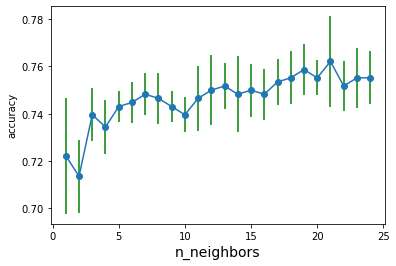

In [92]:
from sklearn.neighbors import KNeighborsClassifier

# Metric for the scoring
scorer = 'accuracy'  # Other possibilities: accuracy, balanced_accuracy, f1, roc_auc, ....
#gide the optimal value of the hyperparameter. #Choose the k value.
#we have to choose a propper k. 
# param_grid
param_grid = {'n_neighbors': range(1,25)}

# Our customized function
grid_knn = hyper_parameters_search(KNeighborsClassifier(), X_train_norm, y_train, param_grid, scorer = scorer)

# do the plotting
plot_cv_scoring(grid_knn,'n_neighbors',scorer, plot_errors = True)

We should be using 21 neighbours to get an accuracy of 0.76

<div class = "alert alert-success">

Which is the optimal value for $k$? You might want to consider
    
- Different score metrics to guide the CV process<br> 
- Plot the CV errors (`plot_errors = True`) 
</div>

## 1.3 Model evaluation

Once we have selected the model (hyper)-parameters, we evaluate its performance

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	78.47	72.92
SEN:	51.74	47.76
ESP:	92.80	86.40
PPV:	79.39	65.31
F1:	62.65	55.17


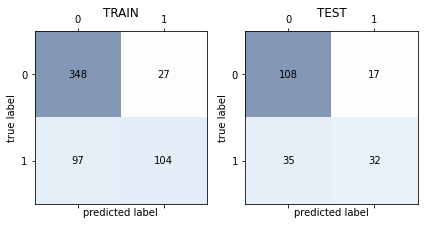

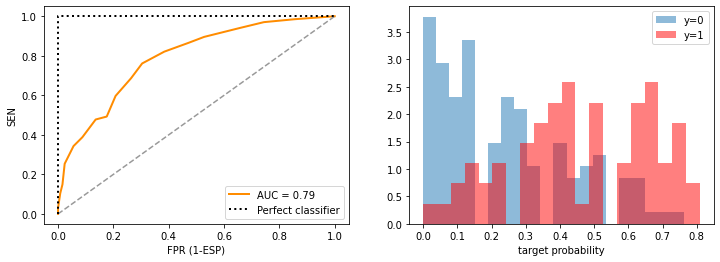

In [93]:
knn_model =  KNeighborsClassifier(**grid_knn.best_params_).fit(X_train_norm,y_train)

analyze_train_test_performance(knn_model,X_train_norm,X_test_norm,y_train,y_test)

<div class = "alert alert-success">
Does this model overfit? Is it better than our baseline?
</div>

We are not having overfit as the difference between the two accuracies is not big enough but the model is not good either. Accuracy is better but sensitivity has been lowered down. 

# 2. Decision trees (DTs)

We will repeat the above process for DTs. In this case, the hyper-parameter is `max_depth`.

## 2.1 Model selection

best mean cross-validation score: 0.741
best parameters: {'max_depth': 2}


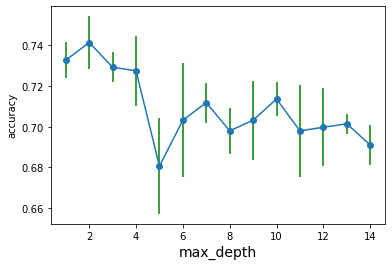

In [94]:
from sklearn.tree import DecisionTreeClassifier

# Decision trees

#from sklearn.model_selection import GridSearchCV

# Metric for the scoring
scorer = 'accuracy'  # Other possibilities: accuracy, balanced_accuracy, f1, roc_auc, ....
#gide the optimal value of the hyperparameter. #Choose the k value.
#we have to choose a propper k. 
# param_grid
param_grid = {'max_depth': range(1,15)}

# Our customized function
grid_tree = hyper_parameters_search(DecisionTreeClassifier(random_state=0), 
X_train_norm, y_train, param_grid, scorer = scorer)

# do the plotting
plot_cv_scoring(grid_tree,'max_depth',scorer, plot_errors = True)

## 2.2 Model evaluation

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	76.04	70.83
SEN:	38.81	29.85
ESP:	96.00	92.80
PPV:	83.87	68.97
F1:	53.06	41.67


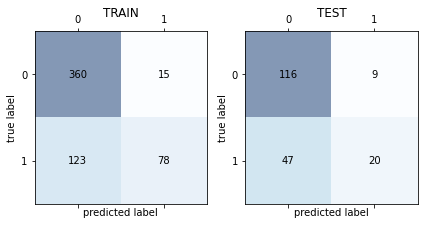

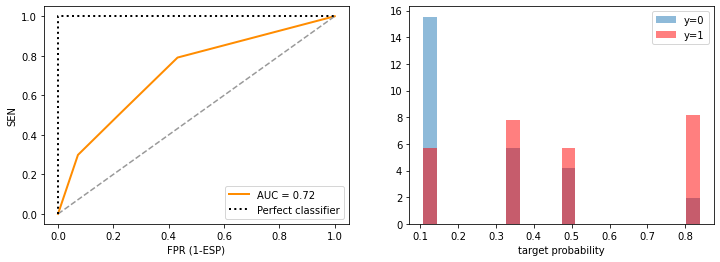

In [95]:
tree_model =  DecisionTreeClassifier(**grid_tree.best_params_).fit(X_train,y_train)

analyze_train_test_performance(tree_model,X_train,X_test,y_train,y_test)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What if we change `max_depth`?

</div>

## 2.3 DTs visualization

Trees can be visualized using the [`plot_tree`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree) function

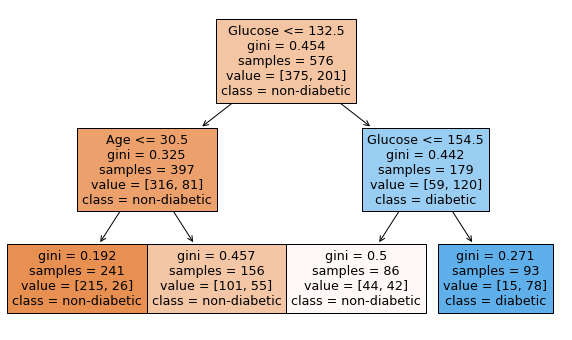

In [96]:
from sklearn.tree import plot_tree

# set plot dimensions
plt.figure(figsize=(10,6))

feature_names=df.columns.drop('Outcome')

plot_tree(
    tree_model,
    feature_names=feature_names, 
    class_names=['non-diabetic','diabetic'], 
    filled=True
)

plt.show()

Be careful when normalizing data because it could get values that do not make sense at first for example, negative data. 

## 2.4 Feature importance

In [97]:
# feature importance
def plot_importances(importances, feat_names):
    
    df_importances = pd.Series(importances, index=feat_names)
    
    plt.figure()
    df_importances.plot.bar()
    plt.ylabel("Feature Importance")
    plt.show()

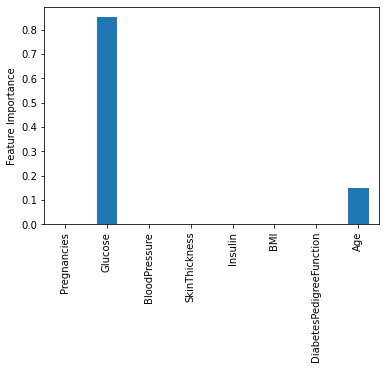

In [98]:
# Plot feature importance
plot_importances(tree_model.feature_importances_, feature_names)

# 3. Random Forest (RF)

In [99]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest
param_grid = {'max_depth': range(1,5),
              'n_estimators' : [50,100,200,500,1000]}

scorer = 'accuracy'  # Other possibilities: accuracy, balanced_accuracy, f1, roc_auc, ....
#gide the optimal value of the hyperparameter. #Choose the k value.
#we have to choose a propper k. 
# param_grid

# Our customized function
grid_tree = hyper_parameters_search(RandomForestClassifier(random_state=0), 
X_train_norm, y_train, param_grid, scorer = scorer)

best mean cross-validation score: 0.780
best parameters: {'max_depth': 4, 'n_estimators': 1000}


PERFORMANCE METRICS
	TRAIN	TEST
ACC:	82.81	73.44
SEN:	60.20	49.25
ESP:	94.93	86.40
PPV:	86.43	66.00
F1:	70.97	56.41


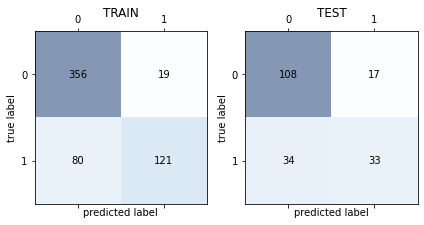

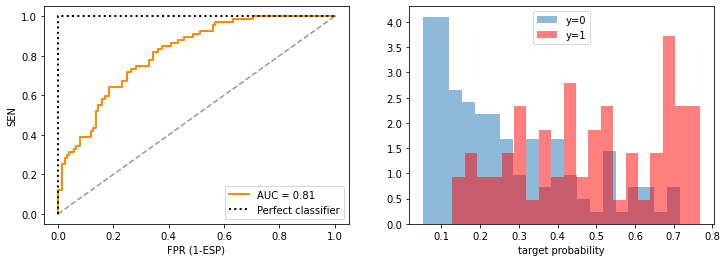

In [100]:
rf_model =  RandomForestClassifier(**grid_tree.best_params_).fit(X_train,y_train)

analyze_train_test_performance(rf_model,X_train,X_test,y_train,y_test)

In [101]:
def plot_importances(importances, feat_names):
    
    df_importances = pd.Series(importances, index=feat_names)
    
    plt.figure()
    df_importances.plot.bar()
    plt.ylabel("Feature Importance")
    plt.show()

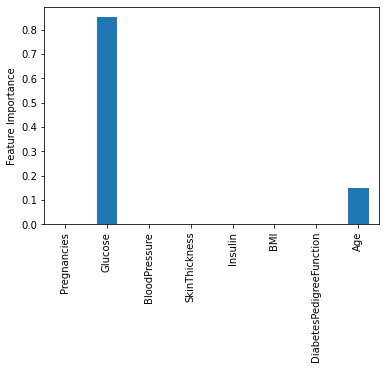

In [102]:
plot_importances(tree_model.feature_importances_, feature_names)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?

</div>

# 4. Gradient Boosting (trees) (BT)

In [103]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators' : [50,100,200,500, 1000, 2000],
    'learning_rate': [0.1,0.05,0.01, 0.005, 0.001], 
    'max_depth': [1, 2]
} 

scorer = 'accuracy'  # Other possibilities: accuracy, balanced_accuracy, f1, roc_auc, ....
#gide the optimal value of the hyperparameter. #Choose the k value.
#we have to choose a propper k. 
# param_grid

# Our customized function
grid_tree = hyper_parameters_search(GradientBoostingClassifier(random_state=0), 
X_train_norm, y_train, param_grid, scorer = scorer)

best mean cross-validation score: 0.773
best parameters: {'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 200}


PERFORMANCE METRICS
	TRAIN	TEST
ACC:	80.56	73.44
SEN:	57.21	46.27
ESP:	93.07	88.00
PPV:	81.56	67.39
F1:	67.25	54.87


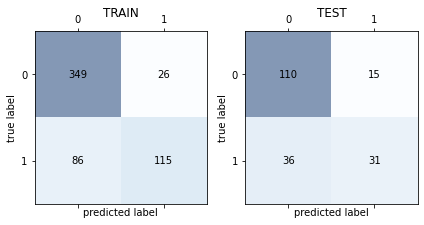

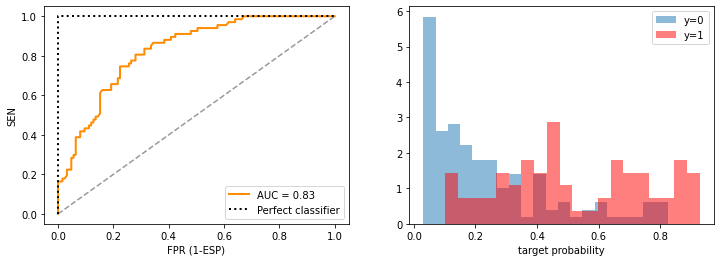

In [104]:
bt_model = GradientBoostingClassifier(**grid_tree.best_params_).fit(X_train,y_train)

analyze_train_test_performance(bt_model,X_train,X_test,y_train,y_test)

In [105]:
def plot_importances(importances, feat_names):
    
    df_importances = pd.Series(importances, index=feat_names)
    
    plt.figure()
    df_importances.plot.bar()
    plt.ylabel("Feature Importance")
    plt.show()

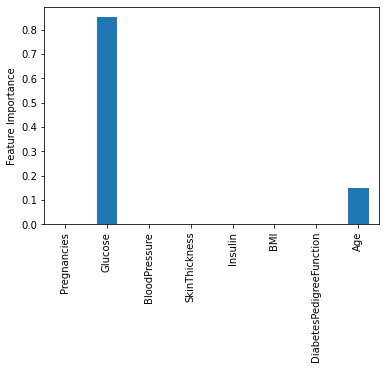

In [106]:
plot_importances(tree_model.feature_importances_, feature_names)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?

</div>

# 5. Multilayer Perceptron (MLP)

In [107]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPClassifier

param_grid = {
    'alpha' : 10.0 ** -np.arange(1, 7), # following recommendation: https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use
    'hidden_layer_sizes': [(5,), (10,), (5,5)] # [(5 neurons, 1 hidden layer), (10 neurons, 1 hidden layer) ,...]
} 

scorer = 'accuracy'  # Other possibilities: accuracy, balanced_accuracy, f1, roc_auc, ....
#gide the optimal value of the hyperparameter. #Choose the k value.
#we have to choose a propper k. 
# param_grid

# Our customized function
grid_tree = hyper_parameters_search(MLPClassifier(random_state=0), 
X_train_norm, y_train, param_grid, scorer = scorer)

best mean cross-validation score: 0.781
best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (10,)}


PERFORMANCE METRICS
	TRAIN	TEST
ACC:	63.02	63.54
SEN:	47.76	43.28
ESP:	71.20	74.40
PPV:	47.06	47.54
F1:	47.41	45.31


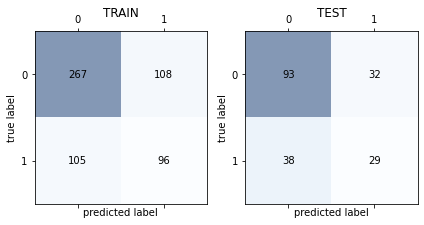

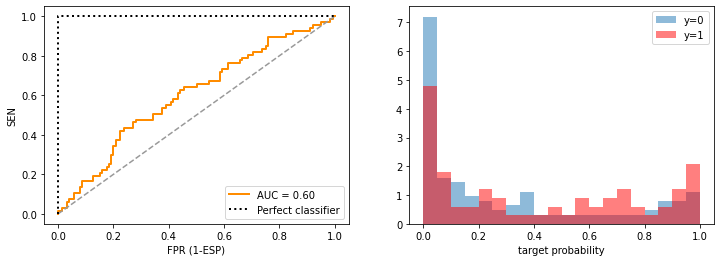

In [108]:
mlp_model = MLPClassifier(**grid_tree.best_params_).fit(X_train,y_train)

analyze_train_test_performance(mlp_model,X_train,X_test,y_train,y_test)

<div class = "alert alert-success">

- Does this model overfit? 
- Is it better than our baseline?
- What are the most important features?

</div>

# 6. Model comparison

If you have done all of the above, just run the following cell

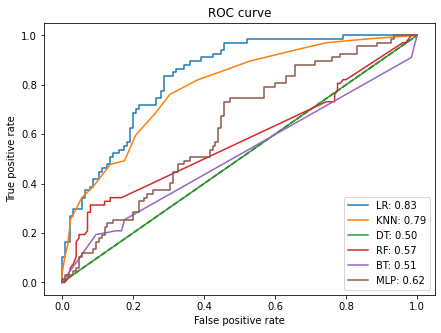

In [109]:
from sklearn.metrics import roc_curve, auc

modelos = {'LR': lr_model, 'KNN':knn_model,'DT':tree_model, 'RF': rf_model, 'BT': bt_model, 'MLP': mlp_model}

plt.figure(figsize=(7,5))
plt.plot([0, 1], [0, 1], 'k--')
for k,v in modelos.items():
    fpr, tpr,_ = roc_curve(y_test, modelos[k].predict_proba(X_test_norm)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = k + ': %0.2f' % roc_auc)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

<div class = "alert alert-success">

Taking into account the above results, in your opinion
    
- What is the best model? Justify your answer 
- And the most important feature(s)? 
- If you want to improve these results, what would you do?

</div>

# 7. Your turn!

<div class = "alert alert-success">

1. Apply non-parametric methods to a regression problem. 
    - Which performance metric would you use?


2. Apply non-parametric methods to your dataset. 

</div> 